In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import models

In [31]:
# ckpt_dir = "checkpoint/wage/lr8lr2_210_testrun-seed-100"
ckpt_dir = "checkpoint/wage/lr8lr2_210_rerun-seed-100"
epoch = 299
data = torch.load(os.path.join(ckpt_dir, "checkpoint-%d.pt"%epoch))
data.keys()

dict_keys(['epoch', 'acc_dict', 'swa_n', 'full_tern', 'low_tern', 'low_acc'])

features.1.weight


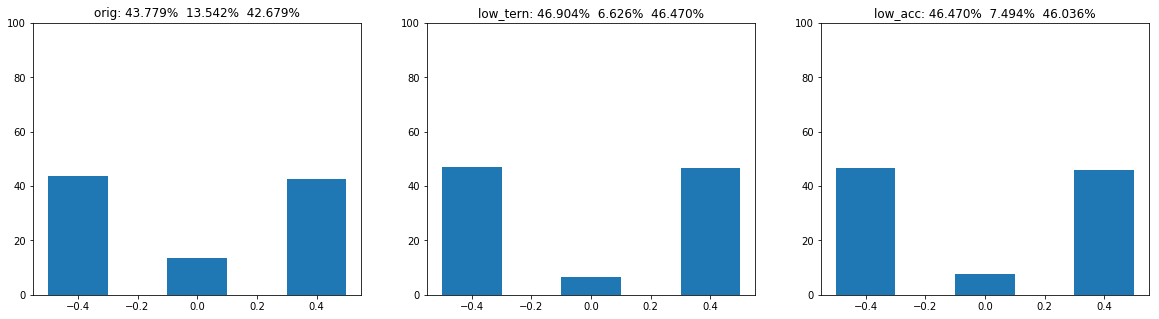

features.4.weight


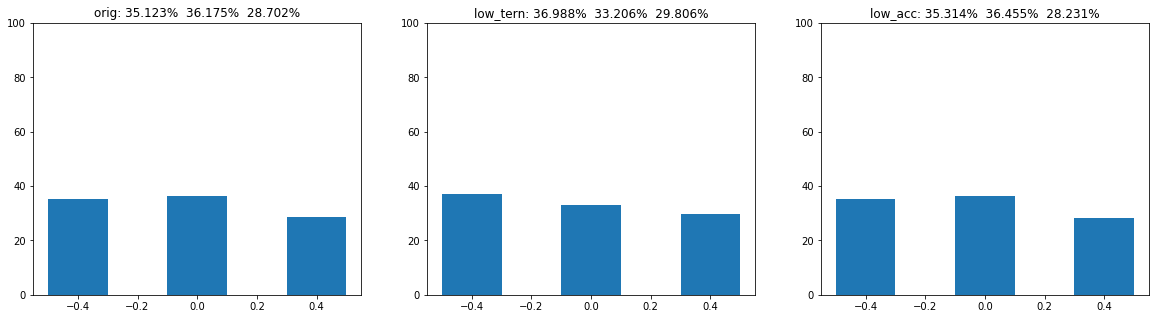

features.8.weight


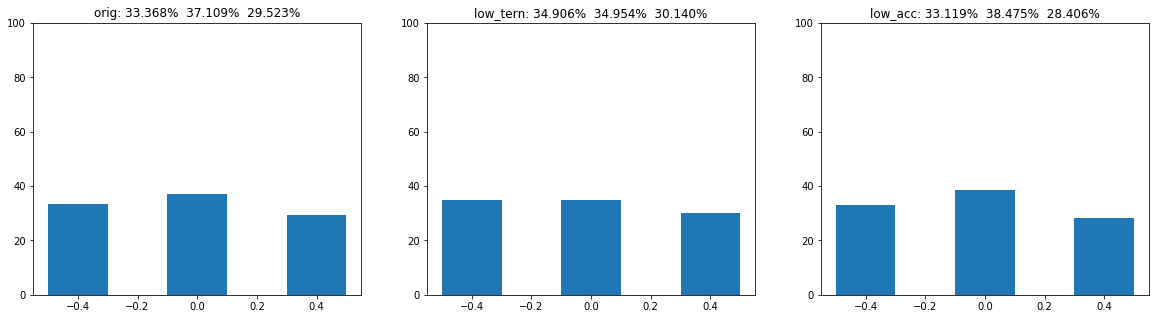

features.11.weight


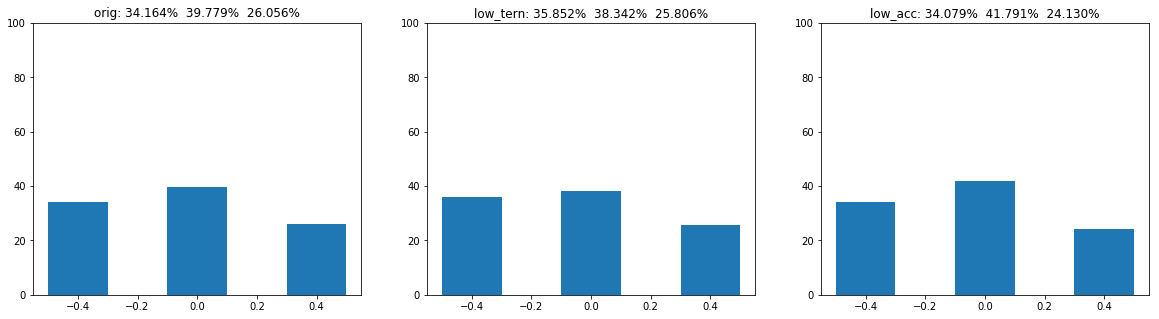

features.15.weight


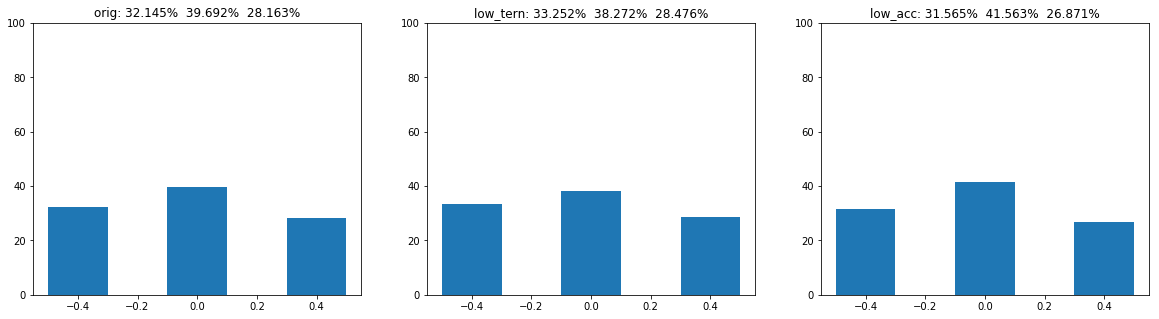

features.18.weight


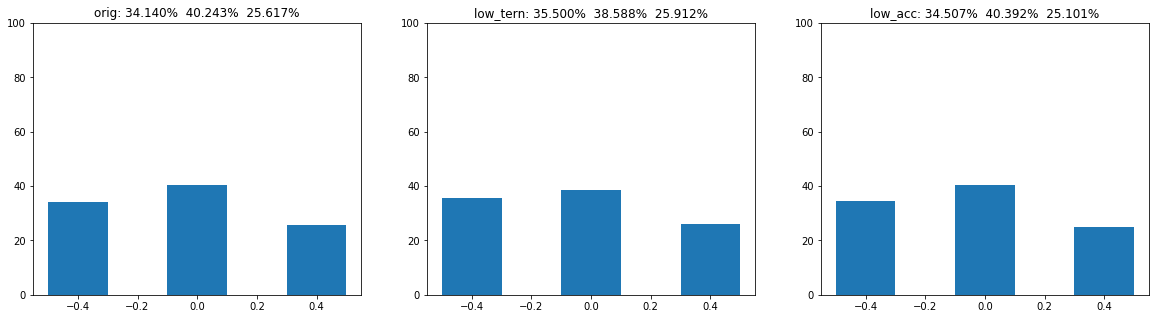

classifier.0.weight


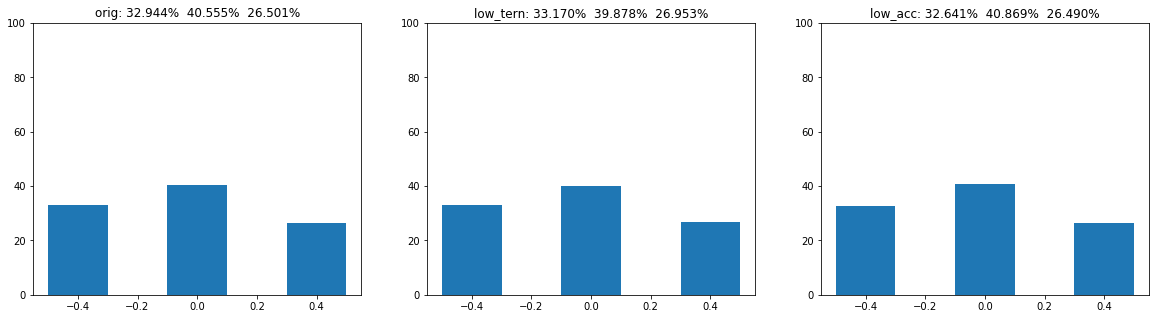

classifier.3.weight


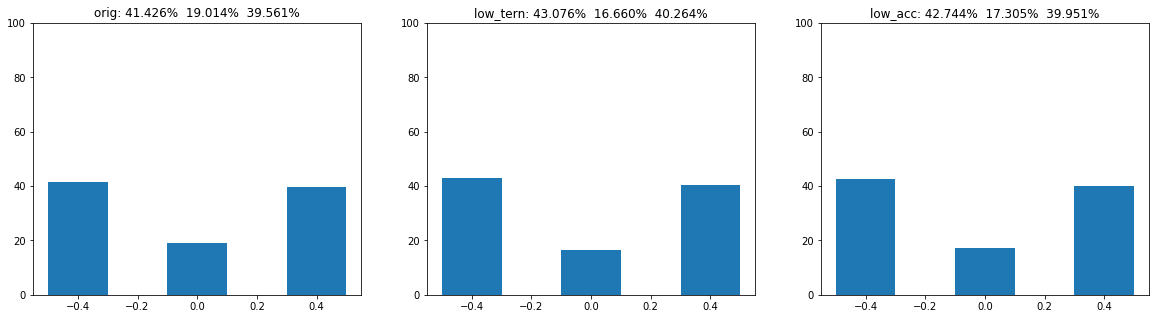

In [32]:
wl = 2
full_tern = {k:models.QW(v, wl).cpu().numpy() for k,v in data['full_tern'].items()}
low_tern = {k:models.QW(v, wl).cpu().numpy() for k,v in data['low_tern'].items()}
low_acc = {k:models.QW(v, wl).cpu().numpy() for k,v in data['low_acc'].items()}
orig = {k:models.QW(v, wl).cpu().numpy() for k,v in data['acc_dict'].items()}
layer_keys = orig.keys()
layer_keys, orig['features.1.weight'].shape

def plot_hist(k, thrs=[0., 0., 0.]):
    plt.figure(figsize=(20,5))
    for i, ((title, wdict), t) in enumerate(zip(
        [("orig",orig), ("low_tern",low_tern), ("low_acc",low_acc)],
        thrs
    )):
        plt.subplot(1,3,i+1)
        flat = wdict[k].flatten()
        plt.hist(flat, bins=5, weights=np.ones_like(flat)/float(len(flat))*100.)
        neg_cnt = (flat < -t).astype(np.int).sum() / float(len(flat)) * 100
        pos_cnt = (flat > t).astype(np.int).sum() / float(len(flat)) * 100
        zeros_cnt = np.logical_and((flat >= -t), (flat <= t)).astype(np.int).sum() / float(len(flat)) * 100
#         plt.bar(np.arange(3), [neg_cnt, zeros_cnt, pos_cnt])
        plt.title("%s: %2.3f%%  %2.3f%%  %2.3f%%"%(title, neg_cnt, zeros_cnt, pos_cnt))
        plt.ylim(0, 100)
#         plt.xticks(np.arange(3), ["-0.5", "0", "0.5"])
#         plt.hist(wdict[k].flatten(), bins=3, range=(-0.5, 0.5), density=True)
    
    plt.show()

for k in layer_keys:
    print(k)
    plot_hist(k, thrs=[0.25, 0.25, 0.25])

features.1.weight


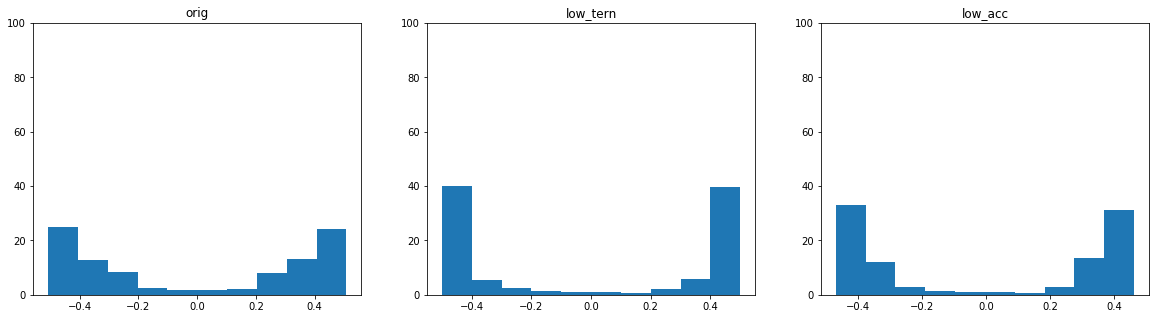

features.4.weight


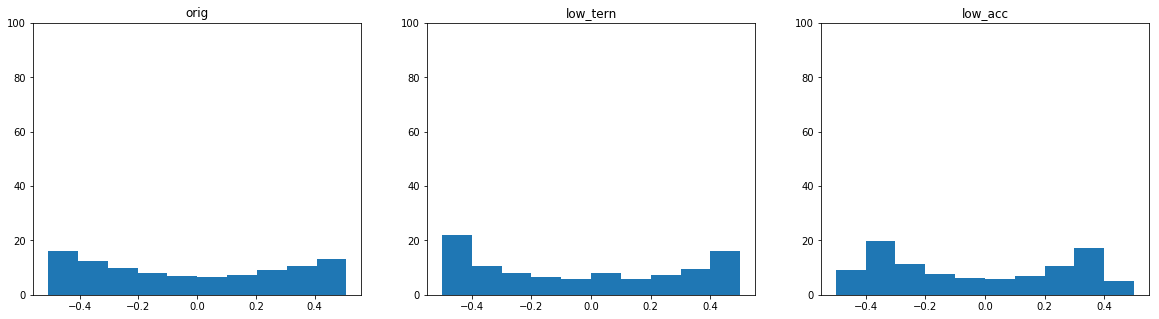

features.8.weight


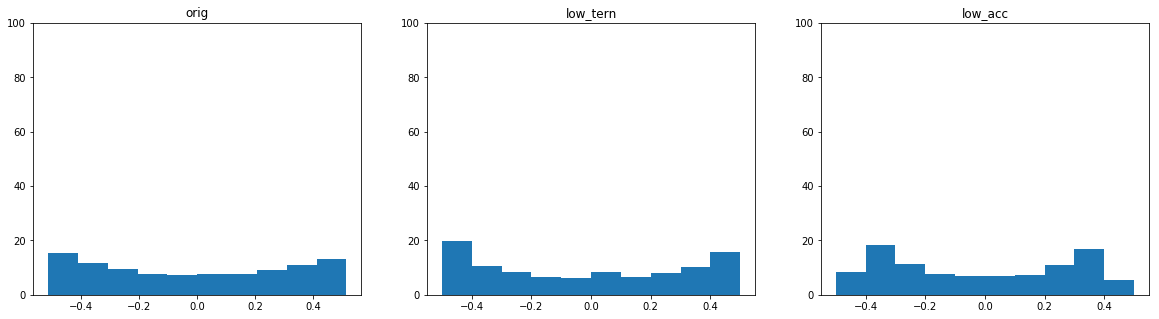

features.11.weight


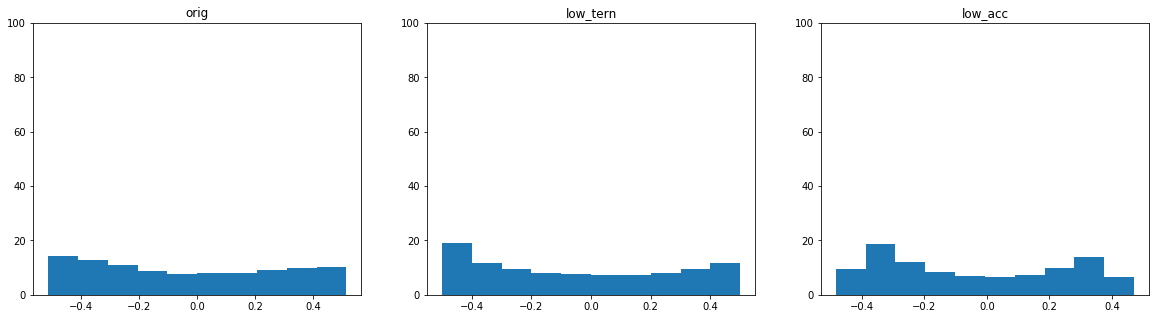

features.15.weight


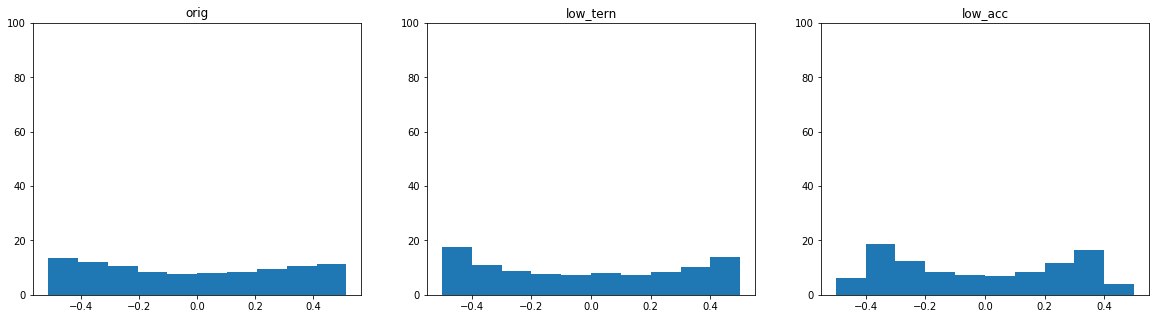

features.18.weight


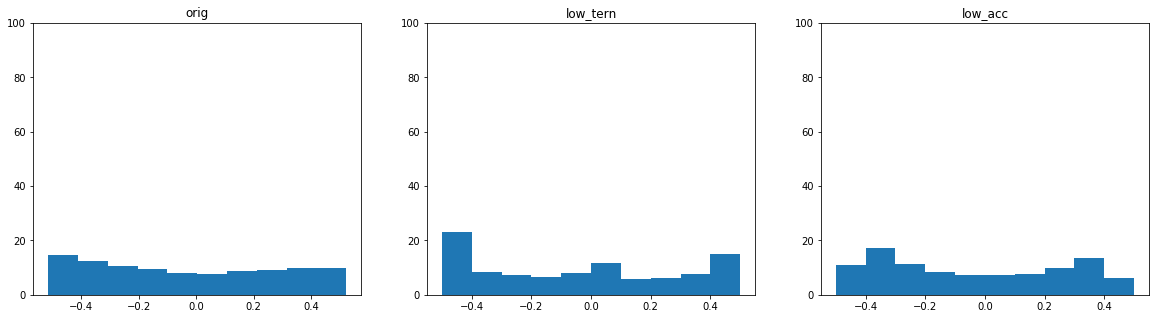

classifier.0.weight


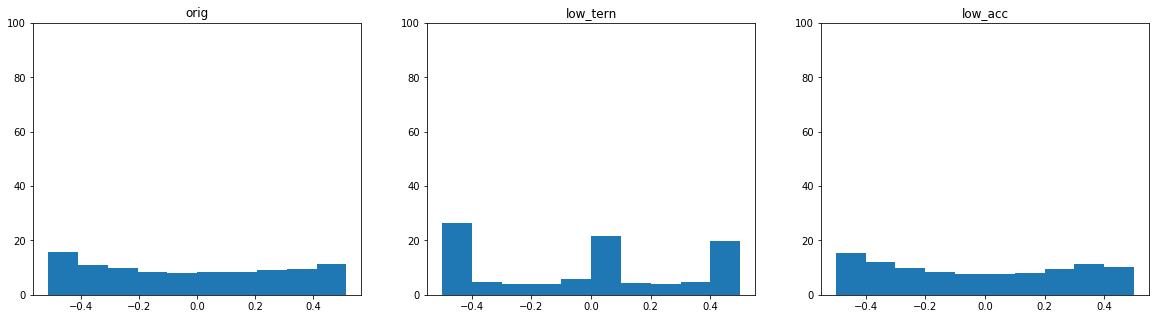

classifier.3.weight


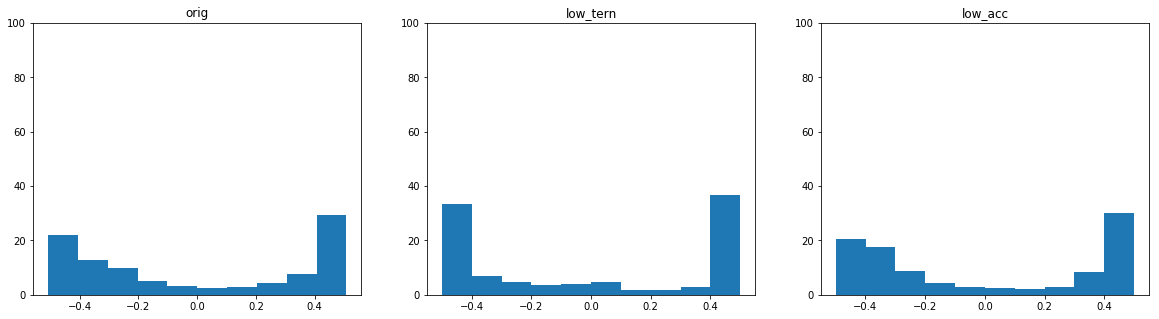

In [33]:
wl = 2
full_tern_bfq = {k:v.cpu().numpy() for k,v in data['full_tern'].items()}
low_tern_bfq = {k:v.cpu().numpy() for k,v in data['low_tern'].items()}
low_acc_bfq = {k:v.cpu().numpy() for k,v in data['low_acc'].items()}
orig_bfq = {k:v.cpu().numpy() for k,v in data['acc_dict'].items()}
layer_keys = orig.keys()
layer_keys, orig['features.1.weight'].shape

def plot_full_hist(k):
    plt.figure(figsize=(20,5))
    for i, (title, wdict) in enumerate([("orig",orig_bfq), ("low_tern",low_tern_bfq), ("low_acc",low_acc_bfq)]):
        plt.subplot(1,3,i+1)
        flat = wdict[k].flatten()
#         plt.hist(flat, density=True, range=(-0.6,0.6))
        plt.hist(flat, density=False, weights=np.ones_like(flat)/float(len(flat))*100.)
        plt.title("%s"%(title))
        plt.ylim(0, 100)
    plt.show()

for k in layer_keys:
    print(k)
    plot_full_hist(k)


In [34]:
from tensorboardX import SummaryWriter
from data_loaders import get_data_loaders
loaders = get_data_loaders('CIFAR10', '.', 0., 128, 0)
writer = SummaryWriter(log_dir="test_run")
model_cfg = models.WAGEVGG7
model_cfg.kwargs.update({
    "wl_activate":8, "fl_activate":-1,
    "wl_error": 8, "fl_error":-1,
    "wl_weight":2,
    "layer_type":'wage'
})
model = model_cfg.base(
    *model_cfg.args,
    num_classes=10, writer=writer,
    **model_cfg.kwargs) 
model.cuda()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


VGG(
  (features): Sequential(
    (0): WAGEQuantizer()
    (1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace)
    (3): WAGEQuantizer()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace)
    (7): WAGEQuantizer()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace)
    (10): WAGEQuantizer()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU(inplace)
    (14): WAGEQuantizer()
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (16): ReLU(inplace)
    (17): WAGEQuantizer()
    (18): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

max:tensor(0.5000, device='cuda:0')
min:tensor(-0.5000, device='cuda:0')


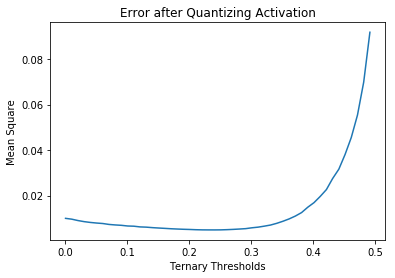

0.241 0.004890393931418657


In [45]:
import torch.nn as nn
quant = lambda name : models.WAGEQuantizer(8, 8, name, writer=None)
conv = nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False)
group1 = nn.Sequential(
    models.WAGEQuantizer(8, -1, "input"),
    conv, nn.ReLU(inplace=True), 
    quant("feature-1-1")
)
group1.cuda()

avg_type = 'full_tern'

b, c, w, h = 128, 3, 32, 32
x = (torch.rand(b, c, w, h)*2-1.).cuda()
k = 'features.1.weight'
conv.weight.data = data[avg_type][k]  / model.weight_scale[k]
baseline = group1.forward(x)

print("max:%s"%data[avg_type][k].max())
print("min:%s"%data[avg_type][k].min())

def quant_with_thres(w, t_neg, t_pos):
    r = torch.zeros_like(w)
    assert t > 0
    r[w>t_pos] = 0.5
    r[w<-t_neg] = -0.5
    return r

errs = []
thrs = np.arange(0.0, 0.5, 0.01) + 1e-3
with torch.no_grad():
    for t in thrs:
        conv.weight.data = quant_with_thres(data[avg_type][k], t, t)/model.weight_scale[k]
        y = group1.forward(x)
        e = ((y - baseline)**2.).sum()/ np.prod(np.array(y.size())).astype(np.float)
        errs.append(e)
    
plt.plot(thrs, errs)
plt.title('Error after Quantizing Activation')
plt.ylabel("Mean Square")
plt.xlabel("Ternary Thresholds")
plt.show()

min_idx = np.argmin(np.array(errs))
print(thrs[min_idx%len(thrs)], errs[min_idx].item())

In [ ]:
# import utils
# criterion = utils.SSE

# wl_weights = 2
# def evalweights(weights):
#     weights = {k:torch.from_numpy(v).cuda() for k,v in weights.items()}
#     for n in weights.keys():
#         model.weight_acc[n] = weights[n]
#     return utils.eval(loaders['test'], model, utils.SSE, 
#                       wage_quantizer=(lambda x,s : models.QW(x,2,s)))
    
# evalweights(full_tern_bfq)